In [3]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()|

LoadError: syntax: incomplete: premature end of input

In [4]:
using LinearAlgebra
using Plots
using ControlSystems

In [5]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

2-element Vector{Float64}:
 0.005000000000000001
 0.1

In [6]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 10.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [7]:
# Initial conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

In [8]:
# Cost weights
Q = Array(1.0*I(2))
R = 0.1 #Array(1.0*I(1))
Qn = Array(1.0*I(2))

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [9]:
#Cost function
function J(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(N-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

J (generic function with 1 method)

## Ricatti Recursion

In [10]:
P = zeros(n, n, N)
K = zeros(m, n, (N-1))

P[:,:,end] .= Qn

# Backward Rollout
for k in (N-1):-1:1
    K[:,:,k] .= (R+B'*P[:,:,k+1]*B)\(B'*P[:,:,k+1]*A)
    P[:,:,k] .= Q + A'P[:,:,k+1]*(A-B*K[:,:,k])
end

x_hist = zeros(n, N)
x_hist[:,1] = x0
u_hist = zeros(m, N-1)

# Forward Rollout
for k in 1:(N-1)
    u_hist[:,k] .= -K[:,:,k] * x_hist[:,k]
    x_hist[:,k+1] .= A*x_hist[:,k] + B*u_hist[k]
end

## Plotting

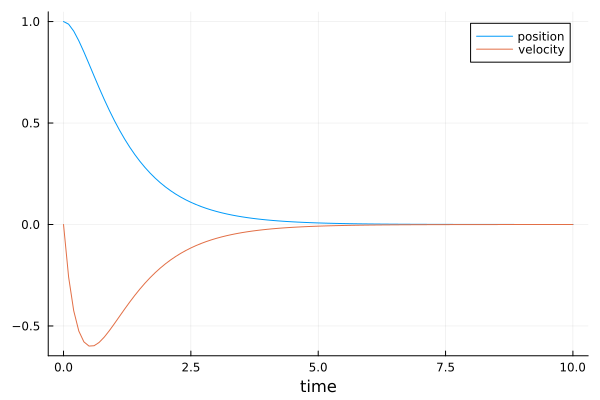

In [11]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times, x_hist[1,:], label="position")
plot!(times, x_hist[2,:], label="velocity")
xlabel!("time")

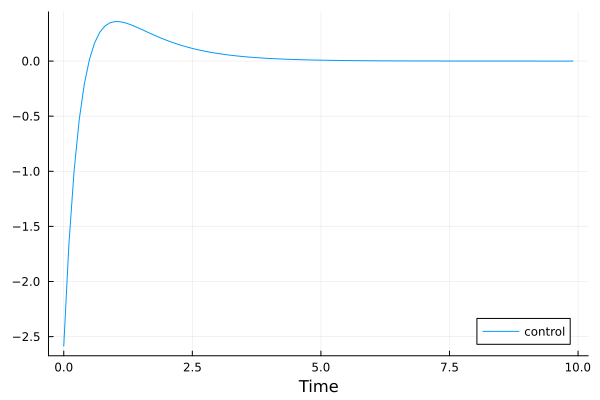

In [12]:
plot(times[1:end-1], u_hist[1,:], label="control")
xlabel!("Time")

In [13]:
J(x_hist,u_hist)

6.658612208961312

## Experiment - Forward rollout with random noise

In [20]:
x_hist = zeros(n, N)
x_hist[:,1] = x0
u_hist = zeros(m, N-1)

# Forward Rollout
for k in 1:(N-1)
    u_hist[:,k] .= -K[:,:,k] * x_hist[:,k]
    x_hist[:,k+1] .= A*x_hist[:,k] + B*u_hist[k] + 0.01 * randn(2)
end

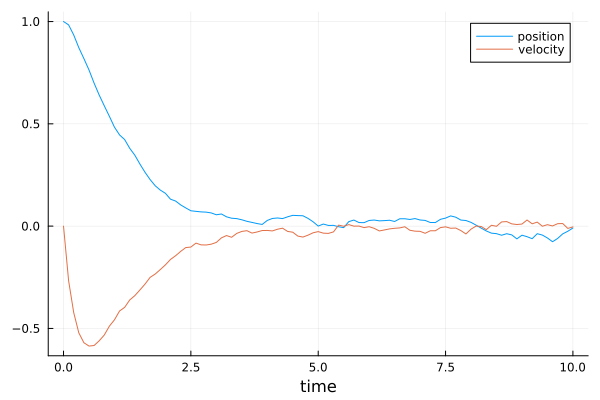

In [21]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times, x_hist[1,:], label="position")
plot!(times, x_hist[2,:], label="velocity")
xlabel!("time")

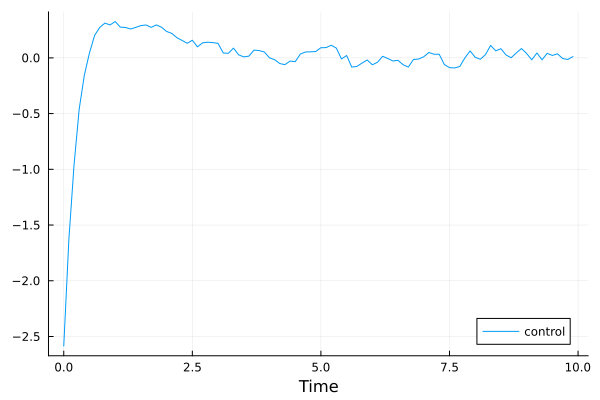

In [22]:
plot(times[1:end-1], u_hist[1,:], label="control")
xlabel!("Time")

## Compute infinite-horizon K matrix using ControlSystems.jl

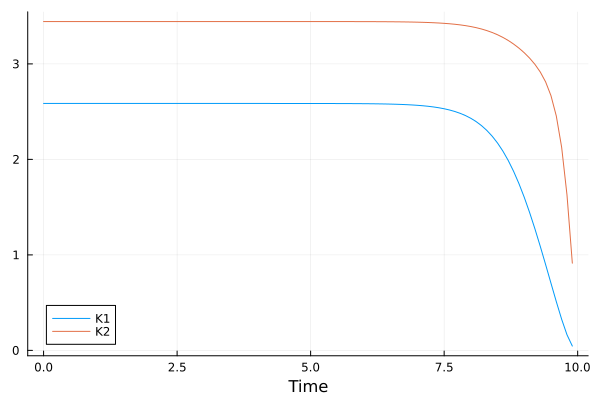

In [26]:
# Plot current K
plot(times[1:end-1], K[1,1,:], label="K1")
plot!(times[1:end-1], K[1,2,:], label="K2")
xlabel!("Time")

In [27]:
K[:,:,1]

1×2 Matrix{Float64}:
 2.5857  3.44344

In [28]:
# Infinite Horizon K from ControlSystems.jl
K_inf = dlqr(A, B, Q, R)
K_inf

1×2 Matrix{Float64}:
 2.5857  3.44344

## Forward rollout with constant K

In [30]:
x_hist = zeros(n, N)
x_hist[:,1] = x0
u_hist = zeros(m, N-1)

# Forward Rollout
for k in 1:(N-1)
    u_hist[:,k] .= -K_inf * x_hist[:,k]
    x_hist[:,k+1] .= A*x_hist[:,k] + B*u_hist[k]
end

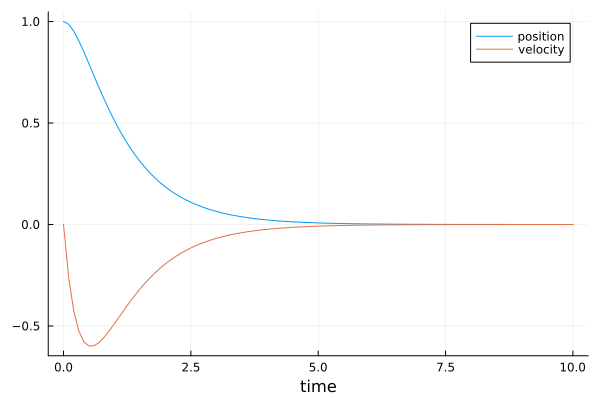

In [31]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times, x_hist[1,:], label="position")
plot!(times, x_hist[2,:], label="velocity")
xlabel!("time")

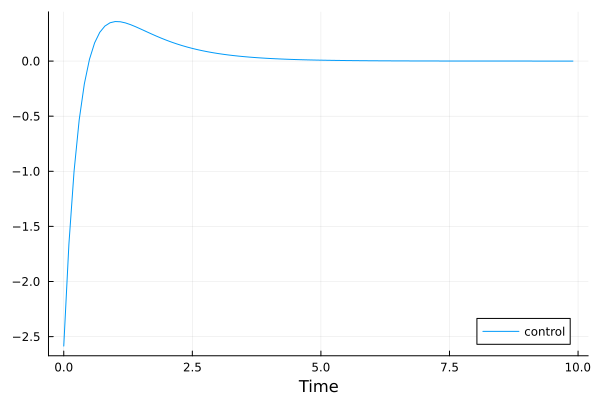

In [32]:
plot(times[1:end-1], u_hist[1,:], label="control")
xlabel!("Time")

In [33]:
eigvals(A - B*K_inf)

2-element Vector{Float64}:
 0.7435575978433926
 0.8991703058887752